<a href="https://colab.research.google.com/github/sanimmazhit/market-basket-analysis/blob/main/notebooks/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

os.environ['KAGGLE_USERNAME'] = "***"
os.environ['KAGGLE_KEY'] = "***"

!kaggle datasets download -d mohamedbakhet/amazon-books-reviews
!unzip -n amazon-books-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
User cancelled operation
^C
Archive:  amazon-books-reviews.zip
  inflating: Books_rating.csv        
  inflating: books_data.csv          


In [2]:
import os
os.makedirs('data', exist_ok=True)
os.makedirs('images', exist_ok=True)


In [3]:
# Setup project folders for GitHub and saving outputs

# Create required folders
import os

os.makedirs("data", exist_ok=True)
os.makedirs("images", exist_ok=True)

# Create .gitkeep files to ensure GitHub tracks the folders
with open("data/.gitkeep", "w") as f:
    pass
with open("images/.gitkeep", "w") as f:
    pass


In [4]:
# Move CSV files into data/ folder
!mkdir -p data
!mv Books_rating.csv data/
!mv books_data.csv data/

In [5]:
import pandas as pd

# Load only review text column
df = pd.read_csv("data/Books_rating.csv", usecols=["review/text"])

# Drop missing or duplicate reviews
df = df.dropna().drop_duplicates(subset=["review/text"])

# Filter out very short or very long reviews
df["review_length"] = df["review/text"].apply(lambda x: len(str(x).split()))
df = df[(df["review_length"] >= 10) & (df["review_length"] <= 100)]

# Use only 1% for initial processing (safe)
df = df.sample(frac=0.01, random_state=42).reset_index(drop=True)


## Part 1: Word-based Market Basket Analysis

In [6]:
import nltk
import re
import string

nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]
    return tokens

df["cleaned_tokens"] = df["review/text"].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
from collections import Counter

# Flatten and count all tokens
all_words = [word for tokens in df["cleaned_tokens"] for word in tokens]
common_words = set([w for w, c in Counter(all_words).most_common(1000)])

# Filter to keep only common words
df["cleaned_tokens"] = df["cleaned_tokens"].apply(lambda tokens: [w for w in tokens if w in common_words])

# Drop empty baskets
df = df[df["cleaned_tokens"].str.len() > 0].reset_index(drop=True)


In [8]:
word_baskets = df["cleaned_tokens"].tolist()


In [9]:
!pip install mlxtend
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(word_baskets).transform(word_baskets)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

In [10]:
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)
frequent_itemsets.sort_values(by="support", ascending=False).head(10)


,support,itemsets
37,0.688905,(book)
278,0.347386,(read)
631,0.257922,"(read, book)"
245,0.206735,(one)
147,0.174506,(great)
145,0.154916,(good)
38,0.147874,(books)
611,0.138395,"(one, book)"
200,0.134423,(like)
321,0.132527,(story)


In [11]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
rules.sort_values(by="confidence", ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
499,"(bought, read)",(book),0.012278,0.688905,0.010743,0.875000,1.270132,1.0,0.002285,2.488760,0.215324,0.015560,0.598194,0.445297
423,"(also, great)",(book),0.015618,0.688905,0.013632,0.872832,1.266985,1.0,0.002873,2.446338,0.214068,0.019731,0.591226,0.446310
61,(covers),(book),0.012639,0.688905,0.010924,0.864286,1.254579,1.0,0.002217,2.292279,0.205517,0.015817,0.563753,0.440071
804,"(think, would)",(book),0.011917,0.688905,0.010292,0.863636,1.253636,1.0,0.002082,2.281364,0.204761,0.014904,0.561666,0.439288
654,"(recommend, like)",(book),0.012278,0.688905,0.010562,0.860294,1.248785,1.0,0.002104,2.226786,0.201698,0.015294,0.550922,0.437813
761,"(understand, read)",(book),0.012910,0.688905,0.011014,0.853147,1.238410,1.0,0.002120,2.118409,0.195031,0.015944,0.527948,0.434567
437,"(anyone, would)",(book),0.017785,0.688905,0.015167,0.852792,1.237895,1.0,0.002915,2.113301,0.195657,0.021932,0.526807,0.437404
42,(bought),(book),0.037194,0.688905,0.031687,0.851942,1.236661,1.0,0.006064,2.101167,0.198764,0.045632,0.524074,0.448969
669,"(loved, read)",(book),0.021035,0.688905,0.017875,0.849785,1.233531,1.0,0.003384,2.071004,0.193387,0.025828,0.517142,0.437866
812,"(ever, books)",(read),0.014444,0.347386,0.012187,0.843750,2.428851,1.0,0.007170,4.176727,0.596905,0.034857,0.760578,0.439417


In [12]:
import os
os.makedirs("images", exist_ok=True)

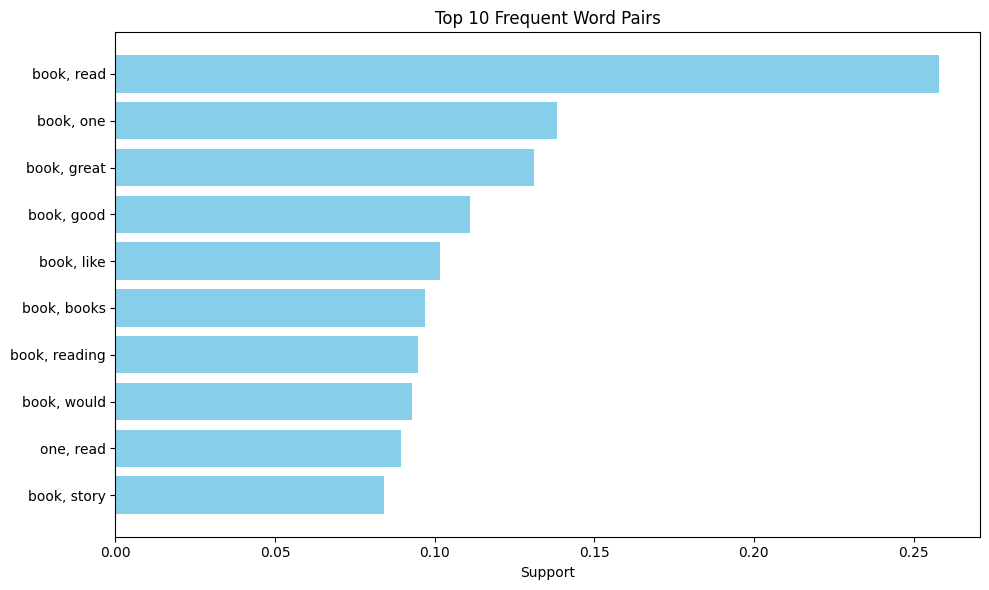

In [13]:
import matplotlib.pyplot as plt
import os

# ✅ Make sure the 'images' folder exists
os.makedirs("images", exist_ok=True)

# Filter itemsets with exactly 2 items
frequent_itemsets["length"] = frequent_itemsets["itemsets"].apply(lambda x: len(x))
top_itemsets = frequent_itemsets[frequent_itemsets["length"] == 2]
top_itemsets = top_itemsets.sort_values(by="support", ascending=False).head(10)

# Create readable itemset names
top_itemsets["itemset_str"] = top_itemsets["itemsets"].apply(lambda x: ", ".join(sorted(x)))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_itemsets["itemset_str"], top_itemsets["support"], color="skyblue")
plt.xlabel("Support")
plt.title("Top 10 Frequent Word Pairs")
plt.gca().invert_yaxis()
plt.tight_layout()

# ✅ Save the plot to the 'images/' folder
plt.savefig("images/frequent_word_pairs.png")
plt.show()


In [14]:
frequent_itemsets.to_csv("data/frequent_itemsets.csv", index=False)
rules.to_csv("data/association_rules.csv", index=False)

## Part 2: The set of books reviewed by same user

In [15]:
df_rating = pd.read_csv("data/Books_rating.csv")
print(df_rating.columns.tolist())


['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness', 'review/score', 'review/time', 'review/summary', 'review/text']


In [16]:
# Create baskets of books reviewed by the same user
# Load user-book data
df_users = pd.read_csv("data/Books_rating.csv", usecols=["User_id", "Title"])

# Drop missing or duplicate user-book entries
df_users = df_users.dropna().drop_duplicates()

# Group titles reviewed by each user
user_baskets = df_users.groupby("User_id")["Title"].apply(list).tolist()

# Remove baskets with less than 2 books (not useful for rules)
user_baskets = [basket for basket in user_baskets if len(basket) > 1]


In [17]:
from mlxtend.preprocessing import TransactionEncoder

# Encode baskets
te_user = TransactionEncoder()
te_user_ary = te_user.fit(user_baskets).transform(user_baskets)
df_user_encoded = pd.DataFrame(te_user_ary, columns=te_user.columns_)

# Find frequent book itemsets
frequent_books = apriori(df_user_encoded, min_support=0.005, use_colnames=True)
frequent_books = frequent_books.sort_values(by="support", ascending=False)
frequent_books.head(10)


,support,itemsets
14,0.012788,(The Hobbit)
15,0.012784,(The Hobbit There and Back Again)
51,0.012784,"(The Hobbit There and Back Again, The Hobbit)"
54,0.012741,"(The Hobbitt, or there and back again; illustr..."
18,0.012741,"(The Hobbitt, or there and back again; illustr..."
57,0.012738,"(The Hobbit There and Back Again, The Hobbitt,..."
103,0.012738,"(The Hobbit There and Back Again, The Hobbitt,..."
52,0.012559,"(The Hobbit, The Hobbit or There and Back Again)"
55,0.012559,"(The Hobbit There and Back Again, The Hobbit o..."
101,0.012559,"(The Hobbit There and Back Again, The Hobbit, ..."


In [18]:
rules_books = association_rules(frequent_books, metric="confidence", min_threshold=0.3)
rules_books = rules_books.sort_values(by="confidence", ascending=False)
rules_books.head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
6,"(The Hobbit There and Back Again, The Hobbitt,...",(The Hobbit),0.012738,0.012788,0.012738,1.0,78.199161,1.0,0.012575,inf,0.999949,0.996084,1.0,0.998042
2377,(The great Gatsby (Leading English literature ...,(The Great Gatsby),0.005022,0.005069,0.005022,1.0,197.291461,1.0,0.004997,inf,0.999953,0.990826,1.0,0.995413
0,(The Hobbit There and Back Again),(The Hobbit),0.012784,0.012788,0.012784,1.0,78.199161,1.0,0.012621,inf,0.999996,0.999720,1.0,0.999860
13,(The Hobbit or There and Back Again),(The Hobbit),0.012559,0.012788,0.012559,1.0,78.199161,1.0,0.012398,inf,0.999768,0.982098,1.0,0.991049
387,(The Lord of the Rings Trilogy: Three Volumes ...,"(The Lord of the Rings (3 Volume Set), The Lor...",0.006603,0.006646,0.006603,1.0,150.463940,1.0,0.006559,inf,0.999957,0.993541,1.0,0.996771
411,"(The Lord of the Rings - Boxed Set, The Lord o...",(The Lord Of The Rings THREE VOLUME BOXED SET ...,0.006592,0.006650,0.006592,1.0,150.383002,1.0,0.006549,inf,0.999942,0.991393,1.0,0.995697
417,"(The Lord of the Rings (3 Volume Set), The Lor...",(The Lord Of The Rings THREE VOLUME BOXED SET ...,0.006592,0.006650,0.006592,1.0,150.383002,1.0,0.006549,inf,0.999942,0.991393,1.0,0.995697
419,"(The Lord of the Rings - Boxed Set, The Lord O...",(The Lord of the Rings (3 Volume Set)),0.006592,0.006646,0.006592,1.0,150.463940,1.0,0.006549,inf,0.999946,0.991927,1.0,0.995963
424,"(The Lord of the Rings - Boxed Set, The Lord o...","(The Lord of the Rings (3 Volume Set), The Lor...",0.006592,0.006646,0.006592,1.0,150.463940,1.0,0.006549,inf,0.999946,0.991927,1.0,0.995963
432,"(The Lord of the Rings - Boxed Set, The Lord o...",(The Lord of the Rings (3 Volume Set)),0.006592,0.006646,0.006592,1.0,150.463940,1.0,0.006549,inf,0.999946,0.991927,1.0,0.995963


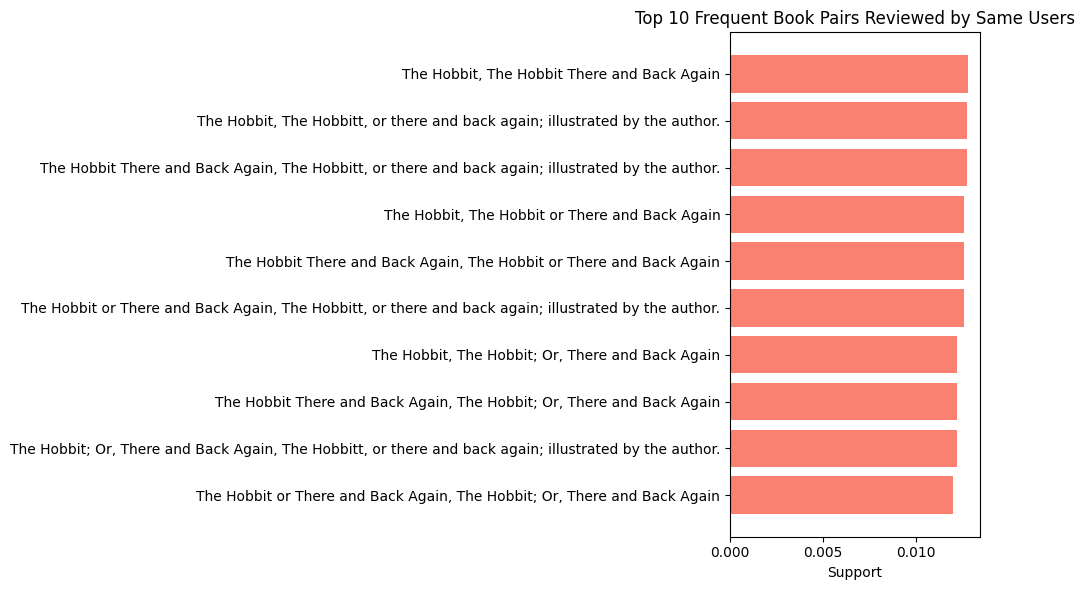

In [19]:
# Filter top 10 frequent book pairs
frequent_books["length"] = frequent_books["itemsets"].apply(lambda x: len(x))
top_books = frequent_books[frequent_books["length"] == 2].head(10)
top_books["itemset_str"] = top_books["itemsets"].apply(lambda x: ", ".join(sorted(x)))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_books["itemset_str"], top_books["support"], color="salmon")
plt.xlabel("Support")
plt.title("Top 10 Frequent Book Pairs Reviewed by Same Users")
plt.gca().invert_yaxis()
plt.tight_layout()

# Save image
plt.savefig("images/frequent_book_pairs.png")
plt.show()


In [20]:
frequent_books.to_csv("data/frequent_books.csv", index=False)
rules_books.to_csv("data/association_rules_books.csv", index=False)
